In [1]:
cd drive/Language_Detection

/content/drive/Language_Detection


In [0]:
# import neccessary libraries 
import tarfile, zipfile
import csv
import os
import pandas as pd
import numpy as np
import time
from numpy import random
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

**Data**

Data used here is from the European Parliament Corpus. The .tar file is unzipped using the lines of code below.

In [0]:
#these lines are executed only the first to extract data from a zip file
languages = tarfile.open("europarl.tgz")
languages.extractall()

The dataset comes in a .txt format, however, it is more convenient to work with data in .csv format. Therefore, a for loop is created to loop through the .txt files line by line and compiled into one csv file for each language.

In [0]:
#creating a list of the different languages
labels = {'Bulgarian': 'bg', 'Czech': 'cs', 'Danish': 'da', 'German':'de', 
          'Greek':'el', 'English':'en','Spanish':'es', 'Estonian':'et', 
          'Finnish':'fi', 'French':'fr', 'Hungarian':'hu', 'Italian':'it', 
          'Lithuanian':'lt', 'Latvian':'lv', 'Dutch':'nl', 'Polish':'pl', 
          'Portuguese':'pt', 'Romanian':'ro', 'Slovak':'sk', 'Slovene':'sl', 
          'Swedish':'sv'}


In [0]:
#path to the where all the files are extracted to
path = 'txt'
directories = os.listdir(path)

In [0]:
#converting txt files to csv
start_time = time.time()
print('Converting txt to csv begun')
for lang in directories:
    print('Converting '+lang+' to csv begun')
    paths = path + '/' + lang
    files = os.listdir(paths)
    lang_type = [lang]
    lang_type = open(lang+'.csv','w')
    for file in files:
        try:
            with open(paths+'/'+file, 'r') as lines:
                for line in lines:
                    lang_type.write(line)
        #this runs when there is an error in decoding
        except UnicodeDecodeError:
            with open(paths+'/'+file, 'r', encoding = 'unicode_escape') as lines:
                for line in lines:
                    lang_type.write(line)
    print("Conversion done \n")
                    
print("--- %s seconds ---" % (time.time() - start_time))
print("Converting from txt to csv done")

**PRE-PROCESSING**

The next box of code deals with cleaning up the data to remove undesirable lines as well as characters common to most languages to improve accuracy of predictions. However, due to computational power constraints, I trained with only 20 percent of the entire corpus.

In [5]:
# pre-processing and cleaning dataset

# create a training dataframe
train_df = pd.DataFrame(columns = ['Sentences','Language_Type'])

# loop through each language and clean
for label in labels.keys():
  print(label,labels[label],'\n') # print language type initialization notification
  try:
    start_time = time.time()
    # load data for individual langauges
    data         = pd.read_csv(labels[label]+'.csv', sep='delimiter', header=None, 
                               engine='python', index_col = False)
    data.columns = ['Sentences']
    data         = data[~data.Sentences.str.contains("<")]
    #characters common to most languages
    characters   = ['1','2','3','4','5','6','7','8','9','0', '@',"'",'#','$','%',
                    '&','/','(',')','"','.',',','?','/','!','=',':',';']
    print(label, 'Data loaded, Pre-processing begun')
    for character in characters:
      data.loc[:,'Sentences'] = data.loc[:,'Sentences'].str.replace(r''+character, 
                                                                    "")
    #indicate corresponding language
    data['Language_Type'] = label
    #take 70000 lines current language of dataset
    data                  = data[:70000]
    #add to train dataframe 
    train_df              = pd.concat([train_df,data], axis=0, ignore_index=True)
    #   
    print("--- %s seconds ---" % (time.time() - start_time))
    print('Pre-processing of ',label,' finished \n')
  
  # decoding error handler    
  except:
    start_time = time.time()
    # load data for individual langauges
    data                     = pd.read_csv(labels[label]+'.csv', sep='delimiter', 
                                           header=None, error_bad_lines=False, 
                                           index_col = False)
    data.columns             = ['Sentences']
    data                     = data[~data.Sentences.str.contains("<")]
    characters = ['1','2','3','4','5','6','7','8','9','0', '@',"'",'#','$','%','&'
                  ,'/','(',')','"','.',',','?','/','!','=',':',';']
    print(label, 'Data loaded, Pre-processing begun (encoding error)')
    for character in characters:
      data.loc[:,'Sentences'] = data.loc[:,'Sentences'].str.replace(r''+character, 
                                                                    "")
  
    data['Language_Type']  = label
    data                  = data[:70000]
    
    train_df = pd.concat([train_df,data], axis=0, ignore_index=True)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    print('Pre-processing of ',label,' finished \n')

Bulgarian bg 

Bulgarian Data loaded, Pre-processing begun
--- 8.948080062866211 seconds ---
Pre-processing of  Bulgarian  finished 

Czech cs 

Czech Data loaded, Pre-processing begun
--- 18.668476819992065 seconds ---
Pre-processing of  Czech  finished 

Danish da 

Danish Data loaded, Pre-processing begun
--- 44.26220512390137 seconds ---
Pre-processing of  Danish  finished 

German de 

German Data loaded, Pre-processing begun
--- 44.37783169746399 seconds ---
Pre-processing of  German  finished 

Greek el 

Greek Data loaded, Pre-processing begun
--- 40.835460901260376 seconds ---
Pre-processing of  Greek  finished 

English en 

English Data loaded, Pre-processing begun
--- 46.416346311569214 seconds ---
Pre-processing of  English  finished 

Spanish es 

Spanish Data loaded, Pre-processing begun
--- 47.63885760307312 seconds ---
Pre-processing of  Spanish  finished 

Estonian et 

Estonian Data loaded, Pre-processing begun
--- 19.47958254814148 seconds ---
Pre-processing of  Est

**Visualization**

Here we visualize the number of lines of sentences contained in datframe by each language

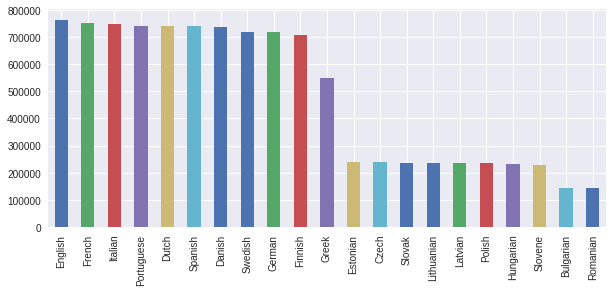

In [6]:
# plot distribution of languages
plt.figure(figsize=(10,4))
train_df.Language_Type.value_counts().plot(kind='bar')

**Train and Test Model**

Here, the dataset split into a train and test datase, using a 70 - 30 train to test test ratio for cross validation

In [0]:
#shuffle dataframe before spliting into train and test for validation
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [0]:
# split training dataset into train and test datasets
X = train_df.Sentences
y = train_df.Language_Type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [0]:
# vectorization and transformation of text in sentences to number vectors
model_LR = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', 
                                                multi_class='multinomial' )),
                    ])

start_time = time.time()
print(' Model training started')
model_LR.fit(X_train, y_train)
print('Model training finished in ',"--- %s seconds ---" % (time.time() - 
                                                            start_time))

y_pred = model_LR.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

 Model training started


In [0]:
# Confusion matrix to check for True and False Positives, True and False Negatives
confusion_matrix(y_pred, y_test)

In [0]:
X = ['Hvis den relevante gennemsigtighed allerede']
model_LR.predict(X)

In [0]:
X = ['Sunt foarte foame și fermecat']
model_LR.predict(X)

In [0]:
X = ['This is amazing']
model_LR.predict(X)